# Imports

In [1]:
# System and Utility Libraries
import os
import shutil
import random
import time
from glob import glob
from concurrent.futures import ThreadPoolExecutor

# Numerical and Data Manipulation Libraries
import numpy as np
import pandas as pd

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Image Processing Libraries
import cv2
from PIL import Image
from tensorflow.keras.preprocessing.image import load_img, img_to_array, save_img
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing import image as keras_image

# Data Augmentation Libraries
from imgaug import augmenters as iaa

# Machine Learning Libraries
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import (
    Dense, Dropout, Flatten, Conv2D, GlobalAveragePooling2D, 
    BatchNormalization, GlobalMaxPooling2D
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import mixed_precision, models, layers, optimizers, losses, metrics
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import (
    EfficientNetB0, EfficientNetB3, ResNet50, MobileNet, VGG16
)
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.saving import register_keras_serializable
from tqdm import tqdm

# Evaluation and Metrics Libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_curve, auc, 
    roc_auc_score, precision_recall_curve, average_precision_score
)
from sklearn.preprocessing import label_binarize

# Tabular Display
from prettytable import PrettyTable


# Copy Data to Local Dir

In [2]:
# Define source and destination directories
dataset_dir = '/kaggle/input/fyp-skin-disease-dataset/FYP skin disease Dataset/images'
input_dir = '/kaggle/working/input_images'

os.makedirs(input_dir, exist_ok=True)
os.system(f'cp -r "{dataset_dir}"/* "{input_dir}/"')

print("All directories and files have been copied successfully.")

All directories and files have been copied successfully.


# Convert to JPG

In [3]:
output_dir = '/kaggle/working/converted_images'

def clear_and_create_dir(directory):
    if os.path.exists(directory):
        shutil.rmtree(directory)
    os.makedirs(directory, exist_ok=True)

clear_and_create_dir(output_dir)

def count_files(directory):
    return sum([len(files) for _, _, files in os.walk(directory)])

# Function to convert a single image
def convert_single_image(img_path, target_folder):
    file = os.path.basename(img_path)
    try:
        if file.lower().endswith('.jpg'):
            shutil.copy(img_path, os.path.join(target_folder, file))
        elif file.lower().endswith(('png', 'jpeg', 'bmp', 'gif')):
            with Image.open(img_path) as img:
                img.convert('RGB').save(os.path.join(target_folder, f"{os.path.splitext(file)[0]}.jpg"), "JPEG")
        return True
    except Exception as e:
        print(f"Skipping image {file} in {img_path}: {e}")
        return False

# Function to process all images concurrently
def convert_images(source_dir, target_dir):
    skipped_images = []
    with ThreadPoolExecutor() as executor:
        futures = []
        for root, _, files in os.walk(source_dir):
            relative_path = os.path.relpath(root, source_dir)
            target_folder = os.path.join(target_dir, relative_path)
            os.makedirs(target_folder, exist_ok=True)
            for file in files:
                img_path = os.path.join(root, file)
                futures.append(executor.submit(convert_single_image, img_path, target_folder))

        for future in futures:
            if not future.result():
                skipped_images.append(future)

    if skipped_images:
        print("List of skipped images:")
        for img in skipped_images:
            print(img)

original_count = count_files(input_dir)
convert_images(input_dir, output_dir)
converted_count = count_files(output_dir)

print("\nFile count comparison:")
print(f"Original: {original_count}, Converted: {converted_count}")


File count comparison:
Original: 23596, Converted: 23593


# Zoom Needed images

In [4]:
def auto_crop(image, tol=5, brightness_threshold=30):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Start with a binary mask to roughly find the lesion's boundaries
    _, mask = cv2.threshold(gray, tol, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(largest_contour)
        
        # Iteratively crop until the edges have sufficient brightness
        while True:
            # Crop based on current bounding box
            cropped_image = image[y:y+h, x:x+w]
            
            # Check brightness levels on the edges
            top_edge = np.mean(cropped_image[0, :])
            bottom_edge = np.mean(cropped_image[-1, :])
            left_edge = np.mean(cropped_image[:, 0])
            right_edge = np.mean(cropped_image[:, -1])
            
            # If all edges have brightness above the threshold, stop cropping
            if min(top_edge, bottom_edge, left_edge, right_edge) > brightness_threshold:
                break
            
            #otherwise adjust bounding box to crop tighter
            y += 1
            h -= 2
            x += 1
            w -= 2

            # Prevent overly aggressive cropping
            if h <= 0.5 * image.shape[0] or w <= 0.5 * image.shape[1]:
                break

        return cropped_image
    return image

def zoom_image(image, zoom_factor=1.3):
    """Applies a zoom effect by cropping a margin from each side."""
    height, width = image.shape[:2]
    new_height, new_width = int(height / zoom_factor), int(width / zoom_factor)

    # Calculate the margins
    top_margin = (height - new_height) // 2
    left_margin = (width - new_width) // 2

    zoomed_image = image[top_margin:top_margin + new_height, left_margin:left_margin + new_width]
    
    # Resize back to original dimensions
    zoomed_image = cv2.resize(zoomed_image, (width, height))
    return zoomed_image

def process_directory(input_dir, tol=5, brightness_threshold=40):
    total_fixed = 0

    for root, dirs, files in os.walk(input_dir):
        for file in files:
            file_path = os.path.join(root, file)
            image = cv2.imread(file_path)

            if image is not None:
                # Check if the image has black borders and fix if necessary
                processed_image = auto_crop(image, tol=tol, brightness_threshold=brightness_threshold)
                
                if not np.array_equal(image, processed_image):
                    processed_image = zoom_image(processed_image, zoom_factor=1.05)
                    total_fixed += 1
                    cv2.imwrite(file_path, processed_image)

    print(f"Total images fixed: {total_fixed}")
    
process_directory(output_dir)

Total images fixed: 3164


# move dark images

In [5]:
# Set the threshold brightness
threshold_brightness = 80
temp_directory = "/kaggle/working/toodarktemp"  # Updated path

if not os.path.exists(temp_directory):
    os.makedirs(temp_directory)

def is_dark_image(image, threshold):
    """Check if the image is dark based on the average brightness."""
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    avg_brightness = np.mean(gray_image)
    return avg_brightness < threshold

dark_images = []
# Traverse all subdirectories and get image paths
for root, dirs, files in os.walk(output_dir):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
            image_path = os.path.join(root, file)
            image = cv2.imread(image_path)
            if image is None:
                continue  # Skip this image if it cannot be read

            if is_dark_image(image, threshold_brightness):
                dark_images.append(image_path)
                shutil.move(image_path, os.path.join(temp_directory, file))

if dark_images:
    print(f'Total bright images moved to "{temp_directory}": {len(dark_images)}')
else:
    print("No dark images found.")

Total bright images moved to "/kaggle/working/toodarktemp": 197


In [6]:
# Set the threshold brightness
threshold_brightness = 230  # Updated for bright images
# Define the temporary directory to move bright images
temp_directory = "/kaggle/working/toobrighttemp"  # Updated path

# Create the temporary directory if it doesn't exist
if not os.path.exists(temp_directory):
    os.makedirs(temp_directory)

def is_bright_image(image, threshold):
    """Check if the image is bright based on the average brightness."""
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    avg_brightness = np.mean(gray_image)
    return avg_brightness > threshold

# List to store bright images
bright_images = []

# Traverse all subdirectories and get image paths
for root, dirs, files in os.walk(output_dir):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
            image_path = os.path.join(root, file)
            image = cv2.imread(image_path)
            if image is None:
                continue  # Skip this image if it cannot be read

            if is_bright_image(image, threshold_brightness):
                bright_images.append(image_path)
                # Move the bright image to the temporary directory
                shutil.move(image_path, os.path.join(temp_directory, file))

# Display summary of moved bright images
if bright_images:
    print(f'Total bright images moved to "{temp_directory}": {len(bright_images)}')
else:
    print("No bright images found.")

Total bright images moved to "/kaggle/working/toobrighttemp": 7


# Darken Bright Images

In [7]:
brightness_threshold = 210  # Adjust this threshold as needed
def calculate_brightness(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    avg_brightness = np.mean(gray_image)
    return avg_brightness

def darken_image(image, brightness):
    if brightness > 240:
        darkening_factor = 0.8  # Significant darkening for brightness > 240
    elif brightness > 230:
        darkening_factor = 0.85  # Moderate darkening for brightness > 230
    elif brightness >= 210:
        darkening_factor = 0.9  # Slight darkening for brightness between 220 and 230
    else:
        darkening_factor = 1.0  # No darkening needed

    darkened_image = np.clip(image * darkening_factor, 0, 255).astype(np.uint8)
    return darkened_image

bright_images = []
image_paths = []

# Walk through the output directory and its subdirectories
for root, dirs, files in os.walk(output_dir):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_path = os.path.join(root, file)
            image = cv2.imread(image_path)
            if image is not None:
                brightness = calculate_brightness(image)
                if brightness > brightness_threshold:
                    bright_images.append(image)
                    image_paths.append(image_path)

bright_count = len(bright_images)
print(f"Images Fixed: {bright_count}")

# Process and rename darkened images
if bright_images:
    for i, (bright_image, original_path) in enumerate(zip(bright_images, image_paths)):
        brightness = calculate_brightness(bright_image)
        darkened_image = darken_image(bright_image, brightness)

        new_filename = f"darkened_{os.path.basename(original_path)}"
        new_path = os.path.join(os.path.dirname(original_path), new_filename)

        cv2.imwrite(new_path, darkened_image)
        os.remove(original_path)  # Remove the original image

    print("Processing complete.")
else:
    print("No bright images found.")

Images Fixed: 483
Processing complete.


In [8]:
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

# Data Split (TRAIN TEST VAL)

In [9]:
seed = 42
random.seed(seed)

dataset_dir = '/kaggle/working/converted_images'
output_dir = '/kaggle/working/split_data'
train_dir = os.path.join(output_dir, 'train')
val_dir = os.path.join(output_dir, 'val')
test_dir = os.path.join(output_dir, 'test')

os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Iterate over each class
for class_name in os.listdir(dataset_dir):
    class_path = os.path.join(dataset_dir, class_name)

    if os.path.isdir(class_path):
        images = os.listdir(class_path)
        train_images, temp_images = train_test_split(images, test_size=0.2, random_state=seed)
        val_images, test_images = train_test_split(temp_images, test_size=0.5, random_state=seed)

        class_train_dir = os.path.join(train_dir, class_name)
        class_val_dir = os.path.join(val_dir, class_name)
        class_test_dir = os.path.join(test_dir, class_name)

        os.makedirs(class_train_dir, exist_ok=True)
        os.makedirs(class_val_dir, exist_ok=True)
        os.makedirs(class_test_dir, exist_ok=True)

        # Copy images to corresponding directories in one go
        for img_set, target_dir in zip([train_images, val_images, test_images],
                                        [class_train_dir, class_val_dir, class_test_dir]):
            for img in img_set:
                shutil.copy(os.path.join(class_path, img), os.path.join(target_dir, img))

print('Data split completed!')

Data split completed!


# **SPlit Orignal Paths**

In [10]:
train_dir = '/kaggle/working/split_data/train'
val_dir = '/kaggle/working/split_data/val'
test_dir = '/kaggle/working/split_data/test'

# Counting Orignal Images

In [11]:
def count_images_in_folders(base_dir):
    folder_counts = {}
    total_images = 0
    for folder_name in os.listdir(base_dir):
        folder_path = os.path.join(base_dir, folder_name)
        if os.path.isdir(folder_path):
            num_images = len(os.listdir(folder_path))
            folder_counts[folder_name] = num_images
            total_images += num_images
    return folder_counts, total_images

train_image_counts, train_total = count_images_in_folders(train_dir)
val_image_counts, val_total = count_images_in_folders(val_dir)
test_image_counts, test_total = count_images_in_folders(test_dir)

total_images = train_total + val_total + test_total
print(f"\nTotal Images: {total_images}")
print(f"Training Images: {train_total} ({train_total/total_images:.2%} of total)")
print(f"Validation Images: {val_total} ({val_total/total_images:.2%} of total)")
print(f"Test Images: {test_total} ({test_total/total_images:.2%} of total)")


Total Images: 23389
Training Images: 18707 (79.98% of total)
Validation Images: 2338 (10.00% of total)
Test Images: 2344 (10.02% of total)


In [12]:
preprocessed_train_dir = '/kaggle/working/preproc/train'
preprocessed_val_dir = '/kaggle/working/preproc/val'
preprocessed_test_dir = '/kaggle/working/preproc/test'

os.makedirs(preprocessed_train_dir, exist_ok=True)
os.makedirs(preprocessed_val_dir, exist_ok=True)
os.makedirs(preprocessed_test_dir, exist_ok=True)

In [13]:
def apply_denoising(image, ksize=(3, 3)):
    denoised_image = cv2.GaussianBlur(image, ksize, 0)
    return denoised_image

def preprocess_images(image_dir, output_dir, display_sample=False):
    # Use glob to search for images recursively inside subdirectories
    image_paths = glob(os.path.join(image_dir, '**', '*.jpg'), recursive=True)
    image_paths += glob(os.path.join(image_dir, '**', '*.jpeg'), recursive=True)
    image_paths += glob(os.path.join(image_dir, '**', '*.png'), recursive=True)
    print(f"Found {len(image_paths)} images in {image_dir}")
    
    if len(image_paths) == 0:
        print(f"No images found in {image_dir}. Please check the directory and file extensions.")
    
    # Select one random image for sample display 
    if display_sample:
        img_path = random.choice(image_paths)
        img = cv2.imread(img_path)
        if img is None:
            print(f"Error loading image: {img_path}")
            return  # Skip this image if it fails to load
        
        denoised_img = apply_denoising(img)

    # Continue processing all images
    for img_path in tqdm(image_paths):
        img = cv2.imread(img_path)
        if img is None:
            print(f"Error loading image: {img_path}")
            continue  
        
        denoised_img = apply_denoising(img)
    
        relative_path = os.path.relpath(img_path, image_dir)
        output_img_path = os.path.join(output_dir, relative_path)
        output_img_dir = os.path.dirname(output_img_path)
        
        os.makedirs(output_img_dir, exist_ok=True)
        cv2.imwrite(output_img_path, denoised_img)

print("Preprocessing training set...")
preprocess_images(train_dir, preprocessed_train_dir, display_sample=True)

print("Preprocessing validation set...")
preprocess_images(val_dir, preprocessed_val_dir, display_sample=True)

print("Preprocessing test set...")
preprocess_images(test_dir, preprocessed_test_dir, display_sample=True)

print("Denoising completed for all sets!")

Preprocessing training set...
Found 18707 images in /kaggle/working/split_data/train


100%|██████████| 18707/18707 [00:38<00:00, 483.81it/s]


Preprocessing validation set...
Found 2338 images in /kaggle/working/split_data/val


100%|██████████| 2338/2338 [00:04<00:00, 485.92it/s]


Preprocessing test set...
Found 2344 images in /kaggle/working/split_data/test


100%|██████████| 2344/2344 [00:04<00:00, 471.90it/s]

Denoising completed for all sets!


# Selecting Number of Training Images (Selecting + Augmenting)

In [14]:
train_dir = '/kaggle/working/preproc/train'
balanced_train_dir = '/kaggle/working/preproc/balanced_train'
target_images = 6000  # Set your target number of images

if os.path.exists(balanced_train_dir):
    shutil.rmtree(balanced_train_dir)  
os.makedirs(balanced_train_dir)  

In [15]:
def random_rotate(image):
    angles = [0, 90, 180, 270]
    angle = tf.random.shuffle(angles)[0]
    return tf.image.rot90(image, k=angle // 90)

In [16]:
def augment_image(image):
    image = tf.image.random_flip_left_right(image) 
    image = tf.image.random_flip_up_down(image)    
    image = random_rotate(image)                 
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, lower=0.7, upper=1.3) 
    return image

In [17]:
overall_start_time = time.time()

# Loop through each class directory in the training set
for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)
    
    if os.path.isdir(class_path):  # Check if it's a directory
        class_start_time = time.time()  

        images = os.listdir(class_path) 
        num_images = len(images)

        # Skip augmentation if the class already has enough images
        if num_images >= target_images:
            print(f"Skipping augmentation for {class_name}")
            
            # Copy the original images to the balanced dataset
            dst = os.path.join(balanced_train_dir, class_name)
            os.makedirs(dst, exist_ok=True)
            for image in images:
                src = os.path.join(class_path, image)
                shutil.copy(src, dst)
        else:
            needed = target_images - num_images
            current_total = num_images

            # Copy original images to the balanced dataset
            dst = os.path.join(balanced_train_dir, class_name)
            os.makedirs(dst, exist_ok=True) 
            for image in images:
                src = os.path.join(class_path, image)
                shutil.copy(src, dst) 

            # Perform augmentation until the target is met
            while current_total < target_images:
                for original_index, image in enumerate(images):
                    src = os.path.join(class_path, image)
                    img = keras_image.load_img(src)
                    img = keras_image.img_to_array(img)  # Convert to NumPy array for TensorFlow processing
                    img = tf.convert_to_tensor(img, dtype=tf.float32)  # Convert to Tensor

                    # Apply augmentation
                    augmented_img = augment_image(img)

                    # Generate unique name for augmented image
                    augmented_img_name = f"aug_{original_index}_{current_total}_{image}"  # Original index added
                    augmented_img = tf.cast(augmented_img, tf.uint8)  # Convert back to uint8
                    augmented_img = Image.fromarray(augmented_img.numpy())  # Convert to PIL image

                    augmented_img.save(os.path.join(dst, augmented_img_name))  # Save augmented image
                    
                    current_total += 1 
                    
                    if current_total >= target_images:
                        break  # Stop if we reach the target

        class_end_time = time.time()
        print(f"Total time for {class_name}: {class_end_time - class_start_time:.2f} seconds")

overall_end_time = time.time()
print(f"Total time for all classes: {overall_end_time - overall_start_time:.2f} seconds")

Total time for SEK: 33.26 seconds
Total time for SCC: 42.15 seconds
Total time for BCC: 31.38 seconds
Total time for DF: 59.22 seconds
Total time for VASC: 60.90 seconds
Skipping augmentation for NV
Total time for NV: 0.77 seconds
Total time for MEL: 17.47 seconds
Total time for Acne: 29.99 seconds
Total time for AK: 42.52 seconds
Total time for all classes: 317.67 seconds


# Count Images(Post Augment)

In [18]:
def count_images_in_folders(base_dir):
    folder_counts = {}
    total_images = 0
    for folder_name in os.listdir(base_dir):
        folder_path = os.path.join(base_dir, folder_name)
        if os.path.isdir(folder_path):
            num_images = len(os.listdir(folder_path))
            folder_counts[folder_name] = num_images
            total_images += num_images
    return folder_counts, total_images

train_image_counts, train_total = count_images_in_folders(balanced_train_dir)
val_image_counts, val_total = count_images_in_folders(val_dir)
test_image_counts, test_total = count_images_in_folders(val_dir)

print("Training Data:")
for disease, count in train_image_counts.items():
    print(f"{disease}: {count} images")

print("\nValidation Data:")
for disease, count in val_image_counts.items():
    print(f"{disease}: {count} images")

print("\nTest Data:")
for disease, count in test_image_counts.items():
    print(f"{disease}: {count} images")

total_images = train_total + val_total + test_total
print(f"\nTotal Images: {total_images}")
print(f"Training Images: {train_total} ({train_total/total_images:.2%} of total)")
print(f"Validation Images: {val_total} ({val_total/total_images:.2%} of total)")
print(f"Test Images: {test_total} ({test_total/total_images:.2%} of total)")

Training Data:
SEK: 6000 images
SCC: 6000 images
BCC: 6000 images
DF: 6000 images
VASC: 6000 images
NV: 7004 images
MEL: 6000 images
Acne: 6000 images
AK: 6000 images

Validation Data:
SEK: 239 images
SCC: 63 images
BCC: 245 images
DF: 34 images
VASC: 82 images
NV: 875 images
MEL: 476 images
Acne: 252 images
AK: 72 images

Test Data:
SEK: 239 images
SCC: 63 images
BCC: 245 images
DF: 34 images
VASC: 82 images
NV: 875 images
MEL: 476 images
Acne: 252 images
AK: 72 images

Total Images: 59680
Training Images: 55004 (92.16% of total)
Validation Images: 2338 (3.92% of total)
Test Images: 2338 (3.92% of total)


# **Load Data**

In [19]:
# Parameters
batch_size = 32
img_height = 300
img_width = 300
num_classes = len(os.listdir(balanced_train_dir))

In [20]:
train_ds = image_dataset_from_directory(balanced_train_dir, image_size=(img_height, img_width), batch_size=batch_size)
val_ds = image_dataset_from_directory(preprocessed_val_dir, image_size=(img_height, img_width), batch_size=batch_size, shuffle=False)
test_ds = image_dataset_from_directory(preprocessed_test_dir, image_size=(img_height, img_width), batch_size=batch_size, shuffle=False)

class_names = sorted(os.listdir(balanced_train_dir))

Found 55004 files belonging to 9 classes.
Found 2338 files belonging to 9 classes.
Found 2344 files belonging to 9 classes.


# ***Creating Model without freezing***

In [21]:
def create_model(base_model, num_classes):
    x = base_model.output
    
    x = GlobalAveragePooling2D()(x)
    
    x = Dropout(0.4)(x)
    
    # Output layer with L2 regularization
    outputs = Dense(num_classes, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    
    model = Model(inputs=base_model.input, outputs=outputs)
    return model

results = []

In [22]:
@register_keras_serializable(package='Custom', name='focal_loss_fixed')
def focal_loss(gamma=2.0, alpha=0.25, num_classes=9):
    def focal_loss_fixed(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, K.epsilon(), 1 - K.epsilon())
        y_true_one_hot = K.one_hot(K.cast(y_true, 'int32'), num_classes)
        cross_entropy_loss = -y_true_one_hot * K.log(y_pred)
        focal_loss = alpha * K.pow(1 - y_pred, gamma) * cross_entropy_loss
        return K.mean(K.sum(focal_loss, axis=1))
    return focal_loss_fixed

In [23]:
# ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.1,
    patience=3,
    mode='max',
    verbose=1
)

In [ ]:
model_name = "EfficientNetB0"

base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
model = create_model(base_model, num_classes)

model.compile(optimizer=Adam(learning_rate=0.0002),
              loss=focal_loss(gamma=2.0, alpha=0.25),  # If using focal loss
              metrics=['accuracy'])

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=5, mode='max', verbose=1),
    ModelCheckpoint(f'best_model_{model_name}.keras', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1),
    reduce_lr
]

start_time = time.time()
history = model.fit(train_ds, validation_data=val_ds, epochs=100, callbacks=callbacks)
train_time = time.time() - start_time

best_val_loss = min(history.history['val_loss'])

eval_start_time = time.time()
test_loss, test_acc = model.evaluate(test_ds)
eval_time = time.time() - eval_start_time
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")
print(f"Evaluation Time: {eval_time:.2f} seconds")

# Store the results with model name
results.append({
    'Model Name': model_name,
    'Test Accuracy': test_acc,
    'Test Loss': test_loss,
    'Best Val Loss': best_val_loss,
    'Training Time (s)': train_time,
    'Evaluation Time (s)': eval_time
})

results_df = pd.DataFrame(results)
print("\nTest Accuracy, Test Loss, and Training Time Comparison Table:")
print(results_df.to_markdown())

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/100


I0000 00:00:1733163789.044917     113 service.cc:145] XLA service 0x7bbc9c0162f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733163789.044986     113 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1733163849.600884     113 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1719/1719 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.7365 - loss: 0.2046
Epoch 1: val_accuracy improved from -inf to 0.87126, saving model to best_model_EfficientNetB0.keras
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 377s 165ms/step - accuracy: 0.7366 - loss: 0.2046 - val_accuracy: 0.8713 - val_loss: 0.0502 - learning_rate: 2.0000e-04
Epoch 2/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.9077 - loss: 0.0381
Epoch 2: val_accuracy improved from 0.87126 to 0.88537, saving model to best_model_EfficientNetB0.keras
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 214s 124ms/step - accuracy: 0.9077 - loss: 0.0381 - val_accuracy: 0.8854 - val_loss: 0.0401 - learning_rate: 2.0000e-04
Epoch 3/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.9400 - loss: 0.0244
Epoch 3: val_accuracy improved from 0.88537 to 0.88922, saving model to best_model_EfficientNetB0.keras
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 214s 125ms/step - accuracy: 0.9400 - loss: 0.0244 - val_accuracy: 0.8892 - val_loss: 0.0389 - lea

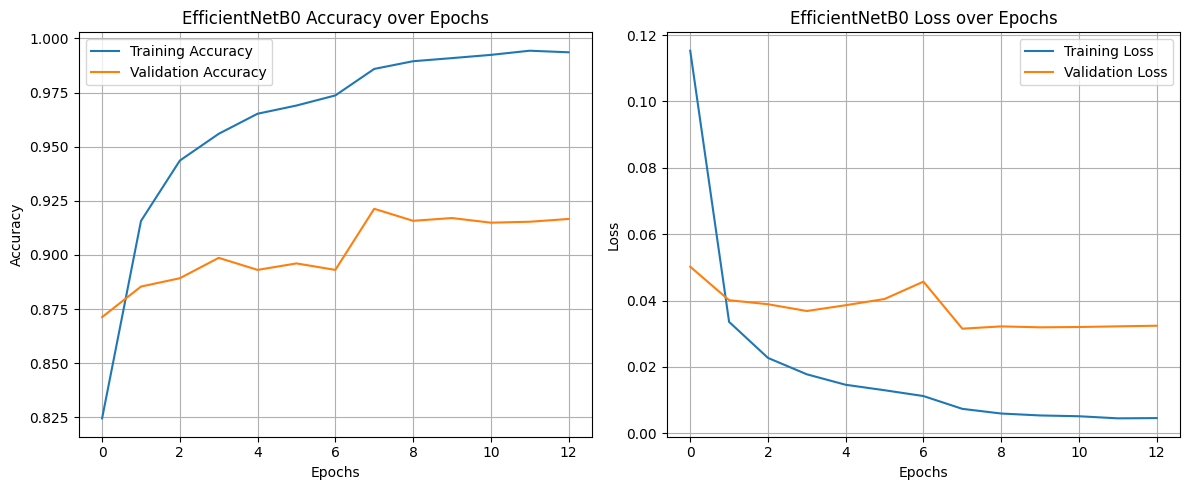

In [25]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title(f'{model_name} Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{model_name} Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [26]:
# Generate predictions on the test dataset
y_pred_probs = model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

# Get true labels from the test dataset
y_true = []
for _, labels in test_ds:
    y_true.extend(labels.numpy())
y_true = np.array(y_true)

report = classification_report(y_true, y_pred, target_names=class_names)
print("\nClassification Report:")
print(report)

74/74 ━━━━━━━━━━━━━━━━━━━━ 12s 93ms/step

Classification Report:
              precision    recall  f1-score   support

          AK       0.86      0.90      0.88        73
        Acne       1.00      1.00      1.00       252
         BCC       0.92      0.93      0.92       246
          DF       0.94      0.86      0.90        35
         MEL       0.91      0.89      0.90       477
          NV       0.93      0.96      0.94       876
         SCC       0.92      0.70      0.79        63
         SEK       0.97      0.93      0.95       239
        VASC       0.96      0.96      0.96        83

    accuracy                           0.93      2344
   macro avg       0.93      0.90      0.92      2344
weighted avg       0.93      0.93      0.93      2344



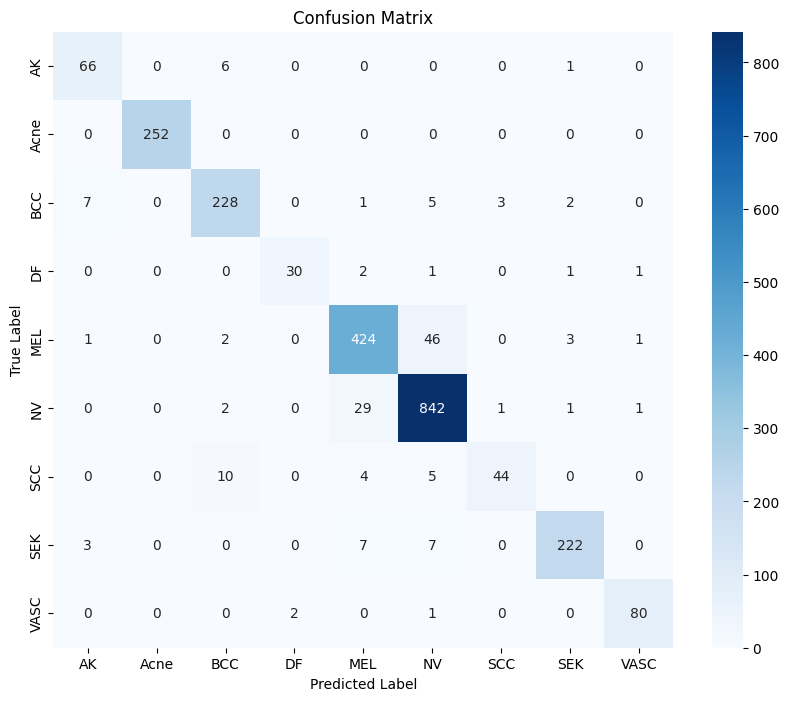

In [27]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


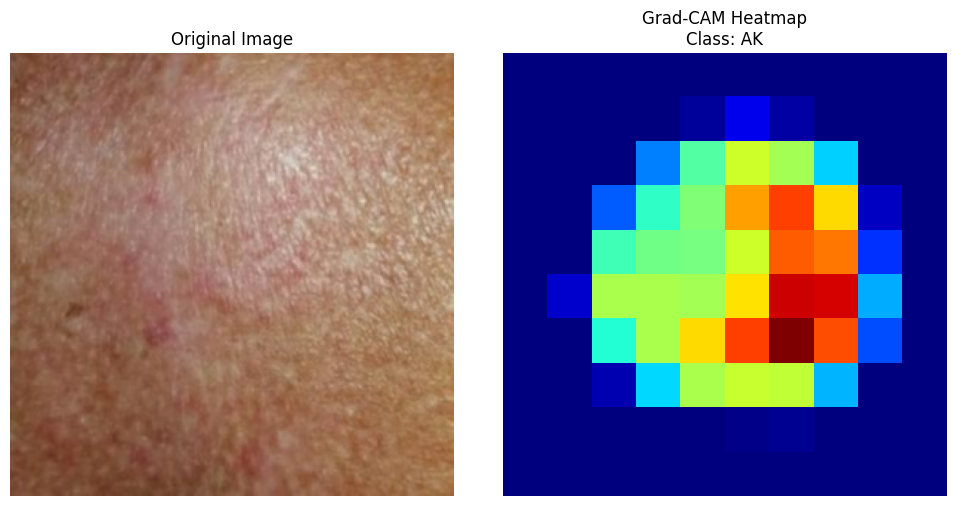

In [28]:
def get_gradcam(model, img_array, class_idx, layer_name):
    """
    Generate Grad-CAM heatmap.
    
    Parameters:
        model (tf.keras.Model): Trained model.
        img_array (numpy array): Preprocessed input image of shape (1, H, W, 3).
        class_idx (int): Target class index.
        layer_name (str): Name of the convolutional layer to visualize.
    
    Returns:
        numpy array: Grad-CAM heatmap.
    """
    # Get the models output for the selected conv layer
    grad_model = Model(inputs=model.input, outputs=[model.get_layer(layer_name).output, model.output])

    # Compute the gradient of the predicted class w.r.t to the feature maps
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, class_idx]
    
    grads = tape.gradient(loss, conv_outputs)

    #Compute guided gradients
    guided_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Weight feature maps with the guided gradients
    conv_outputs = conv_outputs[0]  # Remove batch dimension
    heatmap = tf.reduce_mean(conv_outputs * guided_grads, axis=-1)

    # Normalize heatmap
    heatmap = np.maximum(heatmap, 0)  # ReLU
    heatmap /= tf.reduce_max(heatmap)

    return heatmap.numpy()


def overlay_heatmap(heatmap, img, alpha=0.4):
    """
    Overlay Grad-CAM heatmap on the image.
    
    Parameters:
        heatmap (numpy array): Grad-CAM heatmap.
        img (numpy array): Original image (H, W, 3).
        alpha (float): Transparency of the heatmap.
    
    Returns:
        numpy array: Image with heatmap overlay.
    """
    heatmap = np.uint8(255 * heatmap)
    heatmap = np.expand_dims(heatmap, axis=-1)  # Make it 3D
    heatmap = tf.image.resize(heatmap, (img.shape[0], img.shape[1]))
    heatmap = tf.squeeze(heatmap).numpy()  # Remove unnecessary dimension

    # Apply a colormap
    heatmap = plt.cm.jet(heatmap)[:, :, :3]  # Use only RGB channels

    # Overlay on image
    overlay = img * (1 - alpha) + heatmap * alpha
    overlay = np.clip(overlay, 0, 1)  # Ensure values are in [0, 1]

    return overlay

def visualize_gradcam(model, img, class_names, layer_name):
    """
    Visualize Grad-CAM heatmap for an input image.
    
    Parameters:
        model (tf.keras.Model): Trained model.
        img (numpy array): Original image (H, W, 3).
        class_names (list): List of class names.
        layer_name (str): Name of the convolutional layer to visualize.
    """
    img_array = tf.expand_dims(img, axis=0)  # Add batch dimension
    predictions = model.predict(img_array)
    class_idx = np.argmax(predictions[0])
    
    heatmap = get_gradcam(model, img_array, class_idx, layer_name)
    
    plt.figure(figsize=(10, 5))
    
    # Original img
    plt.subplot(1, 2, 1)
    plt.imshow(img / 255.0)
    plt.title("Original Image")
    plt.axis("off")
    
    # Heatmap
    plt.subplot(1, 2, 2)
    plt.imshow(heatmap, cmap='jet')
    plt.title(f"Grad-CAM Heatmap\nClass: {class_names[class_idx]}")
    plt.axis("off")
    
    plt.tight_layout()
    plt.show()

for img, label in test_ds.take(1):  # Get one batch
    random_index = np.random.choice(img.shape[0])  # Choose a random index from the batch
    visualize_gradcam(model, img[random_index].numpy(), train_ds.class_names, "top_conv")
    break

In [29]:
def dice_coefficient(y_true, y_pred, num_classes):
    """
    Calculate Dice Coefficient for multi-class classification.
    Args:
        y_true: One-hot encoded true labels (Ground truth).
        y_pred: Binary predictions (one-hot encoded).
        num_classes: Number of classes.
    Returns:
        mean_dice: Mean Dice Coefficient across all classes.
        dice_scores: List of Dice Coefficients for each class.
    """
    dice_scores = []
    
    for i in range(num_classes):
        # Extract masks for each class
        y_true_mask = tf.cast(y_true[:, i], tf.float32)
        y_pred_mask = tf.cast(y_pred[:, i], tf.float32)

        #Calculate intersection and union
        intersection = tf.reduce_sum(y_true_mask * y_pred_mask)
        total = tf.reduce_sum(y_true_mask) + tf.reduce_sum(y_pred_mask)

        # Calculate Dice Coefficient
        dice = (2 * intersection) / (total + 1e-6)  #Add epsilon to avoid division by zero
        dice_scores.append(dice.numpy())
    
    # mean Dice Score
    mean_dice = np.mean(dice_scores)
    
    return mean_dice, dice_scores


class_names = test_ds.class_names  # Dynamically extract class names from the dataset
y_pred_probs = model.predict(test_ds)  
y_pred_binary = (y_pred_probs >= 0.5).astype(int)

y_true = []
for _, labels in test_ds:
    y_true.extend(labels.numpy())
y_true = np.array(y_true)

# One-hot encode y_true
num_classes = len(class_names)
y_true_one_hot = to_categorical(y_true, num_classes)

mean_dice, dice_per_class = dice_coefficient(y_true_one_hot, y_pred_binary, num_classes)

table = PrettyTable()
table.field_names = ["Class Name", "Dice Coefficient"]

for name, dice in zip(class_names, dice_per_class):
    table.add_row([name, f"{dice:.4f}"])

table.add_row(["Mean Dice Coefficient", f"{mean_dice:.4f}"])

print(table)

74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step
+-----------------------+------------------+
|       Class Name      | Dice Coefficient |
+-----------------------+------------------+
|           AK          |      0.8919      |
|          Acne         |      1.0000      |
|          BCC          |      0.9206      |
|           DF          |      0.9091      |
|          MEL          |      0.8994      |
|           NV          |      0.9425      |
|          SCC          |      0.7928      |
|          SEK          |      0.9505      |
|          VASC         |      0.9512      |
| Mean Dice Coefficient |      0.9176      |
+-----------------------+------------------+


74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step


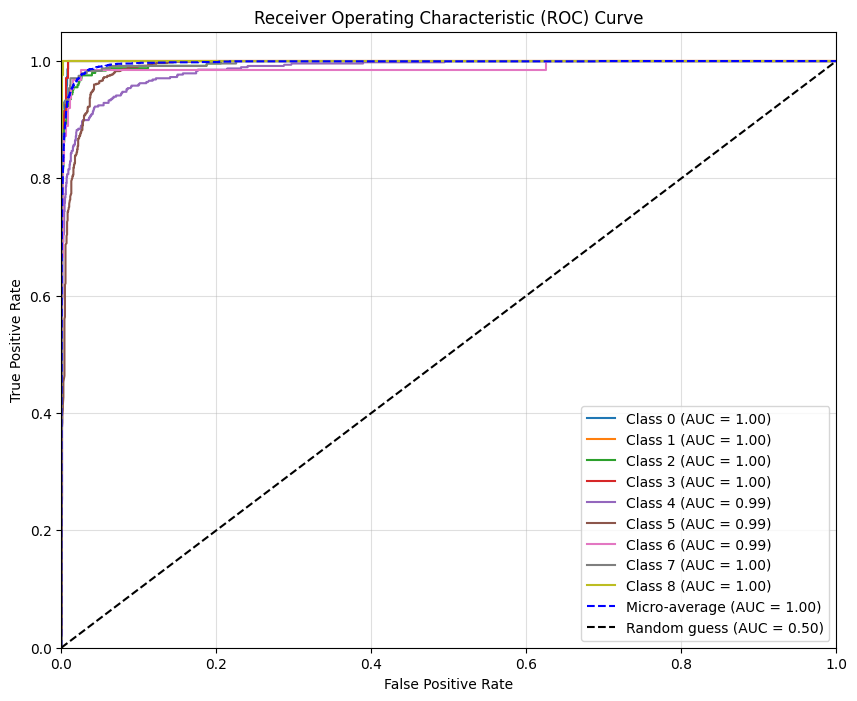

Macro-average AUC-ROC score: 0.9949


In [30]:
# Get predictions and true labels
y_true = np.concatenate([y for x, y in test_ds], axis=0)  # True labels
y_pred_probs = model.predict(test_ds)  # Predicted probabilities

# binarize labels for multiclass ROC
n_classes = num_classes  # Replace with the number of classes in your dataset
y_true_binarized = label_binarize(y_true, classes=np.arange(n_classes))

# Compute ROC curve and ROC area for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"Class {i} (AUC = {roc_auc[i]:.2f})")

# Compute and plot the micro-avg ROC curve
fpr_micro, tpr_micro, _ = roc_curve(y_true_binarized.ravel(), y_pred_probs.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)
plt.plot(fpr_micro, tpr_micro, label=f"Micro-average (AUC = {roc_auc_micro:.2f})", linestyle="--", color="blue")

plt.plot([0, 1], [0, 1], "k--", label="Random guess (AUC = 0.50)")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.grid(alpha=0.4)
plt.show()

roc_auc_macro = roc_auc_score(y_true_binarized, y_pred_probs, average="macro")
print(f"Macro-average AUC-ROC score: {roc_auc_macro:.4f}")

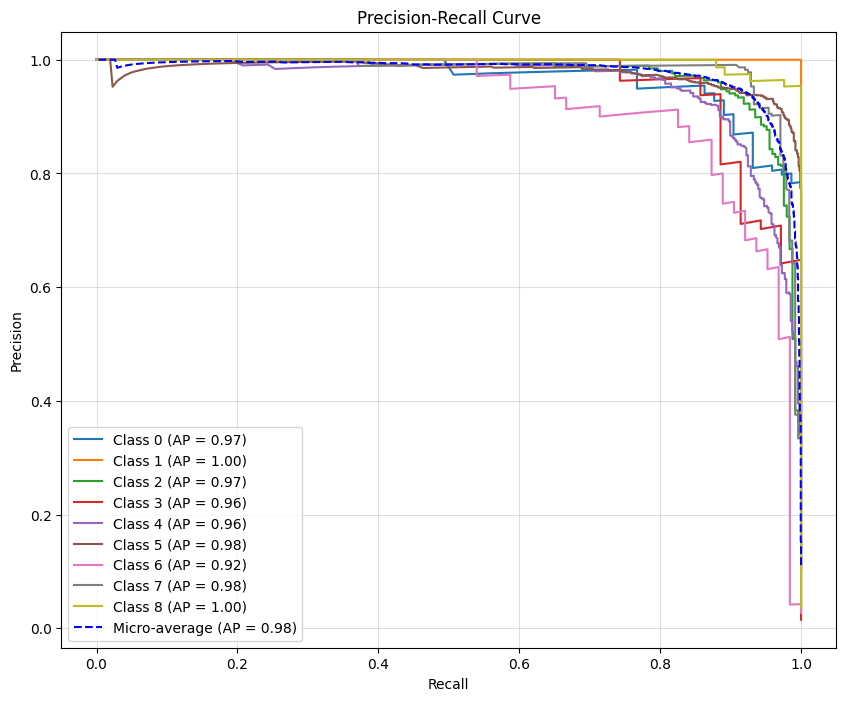

Macro-average Precision-Recall score: 0.9713


In [31]:
precision = {}
recall = {}
average_precision = {}

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_true_binarized[:, i], y_pred_probs[:, i])
    average_precision[i] = average_precision_score(y_true_binarized[:, i], y_pred_probs[:, i])

plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(recall[i], precision[i], label=f"Class {i} (AP = {average_precision[i]:.2f})")

precision_micro, recall_micro, _ = precision_recall_curve(y_true_binarized.ravel(), y_pred_probs.ravel())
average_precision_micro = average_precision_score(y_true_binarized, y_pred_probs, average="micro")
plt.plot(recall_micro, precision_micro, label=f"Micro-average (AP = {average_precision_micro:.2f})", linestyle="--", color="blue")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(loc="lower left")
plt.grid(alpha=0.4)
plt.show()

average_precision_macro = average_precision_score(y_true_binarized, y_pred_probs, average="macro")
print(f"Macro-average Precision-Recall score: {average_precision_macro:.4f}")

In [32]:
model.save(f'final_model_{model_name}.h5')

In [33]:
@register_keras_serializable(package='Custom', name='focal_loss_fixed')
def focal_loss_fixed(y_true, y_pred, gamma=2.0, alpha=0.25, num_classes=9):
    y_pred = tf.clip_by_value(y_pred, K.epsilon(), 1 - K.epsilon())
    y_true_one_hot = K.one_hot(K.cast(y_true, 'int32'), num_classes)
    cross_entropy_loss = -y_true_one_hot * K.log(y_pred)
    focal_loss = alpha * K.pow(1 - y_pred, gamma) * cross_entropy_loss
    return K.mean(K.sum(focal_loss, axis=1))

# Load the model with the custom loss function
model = load_model('final_model_EfficientNetB0.h5', 
                   custom_objects={'focal_loss_fixed': focal_loss_fixed})

# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_ds)

# Print the test results
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

74/74 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - accuracy: 0.9351 - loss: 0.0260
Test Loss: 0.028817029669880867
Test Accuracy: 0.9334471225738525


# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

In [ ]:
model_name = "EfficientNetB3"

base_model = EfficientNetB3(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
model = create_model(base_model, num_classes)

model.compile(optimizer=Adam(learning_rate=0.0002),
              loss=focal_loss(gamma=2.0, alpha=0.25),  # If using focal loss
              metrics=['accuracy'])

callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=5, mode='max', verbose=1),
    ModelCheckpoint(f'best_model_{model_name}.keras', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1),
    reduce_lr
]

start_time = time.time()
history = model.fit(train_ds, validation_data=val_ds, epochs=100, callbacks=callbacks)
train_time = time.time() - start_time

best_val_loss = min(history.history['val_loss'])

eval_start_time = time.time()
test_loss, test_acc = model.evaluate(test_ds)
eval_time = time.time() - eval_start_time
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")
print(f"Evaluation Time: {eval_time:.2f} seconds")

results.append({
    'Model Name': model_name,
    'Test Accuracy': test_acc,
    'Test Loss': test_loss,
    'Best Val Loss': best_val_loss,
    'Training Time (s)': train_time,
    'Evaluation Time (s)': eval_time
})

results_df = pd.DataFrame(results)
print("\nTest Accuracy, Test Loss, and Training Time Comparison Table:")
print(results_df.to_markdown())

43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/100


I0000 00:00:1733166932.707782     112 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_1276', 4 bytes spill stores, 4 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_1016', 4 bytes spill stores, 4 bytes spill loads



1718/1719 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.7741 - loss: 0.1839

I0000 00:00:1733167445.035441     110 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_673', 4 bytes spill stores, 4 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_558', 4 bytes spill stores, 4 bytes spill loads



1719/1719 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - accuracy: 0.7742 - loss: 0.1838
Epoch 1: val_accuracy improved from -inf to 0.87725, saving model to best_model_EfficientNetB3.keras
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 710s 309ms/step - accuracy: 0.7742 - loss: 0.1838 - val_accuracy: 0.8772 - val_loss: 0.0431 - learning_rate: 2.0000e-04
Epoch 2/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.9252 - loss: 0.0305
Epoch 2: val_accuracy improved from 0.87725 to 0.89264, saving model to best_model_EfficientNetB3.keras
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 393s 229ms/step - accuracy: 0.9252 - loss: 0.0305 - val_accuracy: 0.8926 - val_loss: 0.0363 - learning_rate: 2.0000e-04
Epoch 3/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.9477 - loss: 0.0205
Epoch 3: val_accuracy improved from 0.89264 to 0.89478, saving model to best_model_EfficientNetB3.keras
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 395s 230ms/step - accuracy: 0.9477 - loss: 0.0205 - val_accuracy: 0.8948 - val_loss: 0.0338 - lea

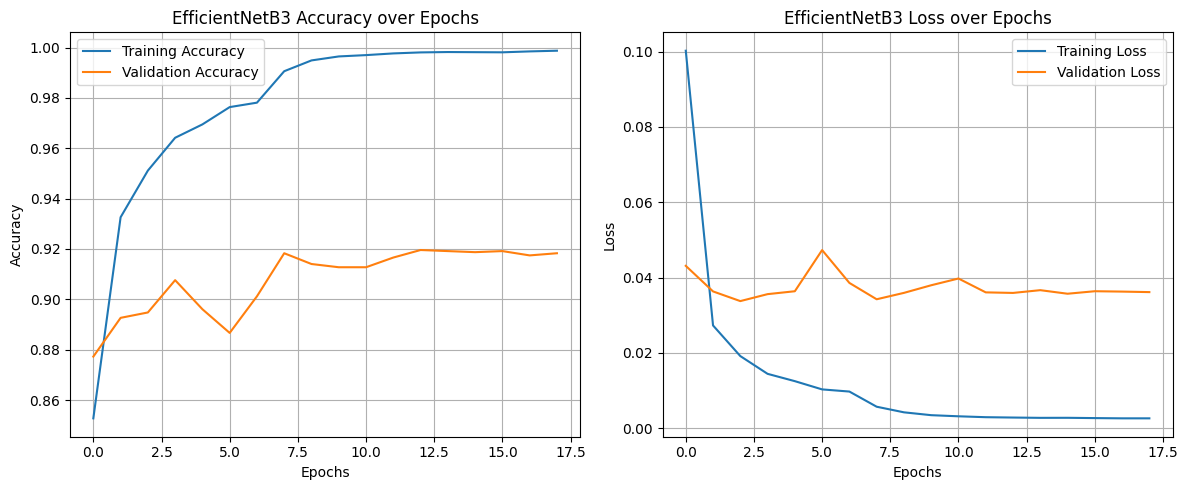

In [35]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title(f'{model_name} Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{model_name} Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [36]:
y_pred_probs = model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

y_true = []
for _, labels in test_ds:
    y_true.extend(labels.numpy())
y_true = np.array(y_true)

report = classification_report(y_true, y_pred, target_names=class_names)
print("\nClassification Report:")
print(report)

74/74 ━━━━━━━━━━━━━━━━━━━━ 18s 147ms/step

Classification Report:
              precision    recall  f1-score   support

          AK       0.91      0.93      0.92        73
        Acne       0.99      1.00      0.99       252
         BCC       0.94      0.93      0.94       246
          DF       0.97      0.91      0.94        35
         MEL       0.92      0.87      0.90       477
          NV       0.92      0.96      0.94       876
         SCC       0.93      0.86      0.89        63
         SEK       0.97      0.95      0.96       239
        VASC       0.96      0.96      0.96        83

    accuracy                           0.94      2344
   macro avg       0.95      0.93      0.94      2344
weighted avg       0.94      0.94      0.94      2344



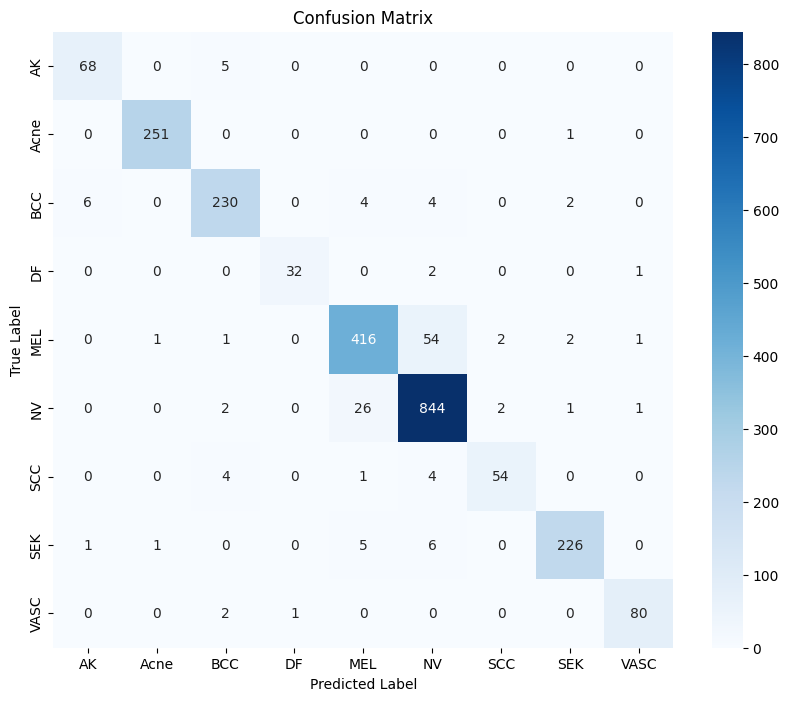

In [37]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [38]:
class_names = test_ds.class_names  # Dynamically extract class names from the dataset

y_pred_probs = model.predict(test_ds)  

y_pred_binary = (y_pred_probs >= 0.5).astype(int)

y_true = []
for _, labels in test_ds:
    y_true.extend(labels.numpy())
y_true = np.array(y_true)

# One-hot encode y_true
num_classes = len(class_names)
y_true_one_hot = to_categorical(y_true, num_classes)

mean_dice, dice_per_class = dice_coefficient(y_true_one_hot, y_pred_binary, num_classes)

table = PrettyTable()
table.field_names = ["Class Name", "Dice Coefficient"]

for name, dice in zip(class_names, dice_per_class):
    table.add_row([name, f"{dice:.4f}"])

table.add_row(["Mean Dice Coefficient", f"{mean_dice:.4f}"])

# Print the table
print(table)

74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step
+-----------------------+------------------+
|       Class Name      | Dice Coefficient |
+-----------------------+------------------+
|           AK          |      0.9116      |
|          Acne         |      0.9921      |
|          BCC          |      0.9342      |
|           DF          |      0.9412      |
|          MEL          |      0.8963      |
|           NV          |      0.9429      |
|          SCC          |      0.8814      |
|          SEK          |      0.9552      |
|          VASC         |      0.9639      |
| Mean Dice Coefficient |      0.9354      |
+-----------------------+------------------+


74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step


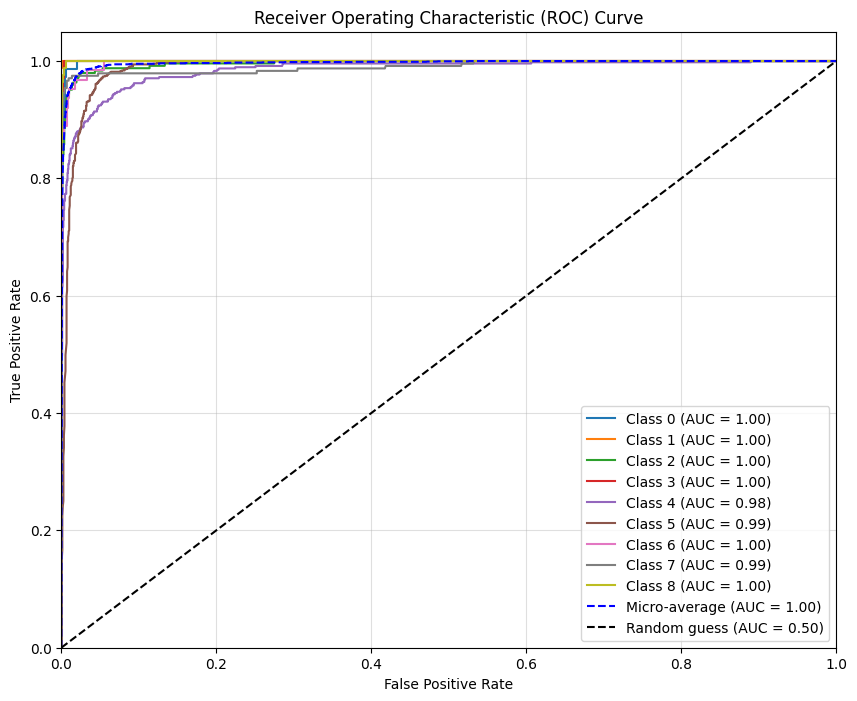

Macro-average AUC-ROC score: 0.9952


In [39]:

y_true = np.concatenate([y for x, y in test_ds], axis=0)  # True labels
y_pred_probs = model.predict(test_ds)  # Predicted probabilities

n_classes = num_classes  
y_true_binarized = label_binarize(y_true, classes=np.arange(n_classes))

fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"Class {i} (AUC = {roc_auc[i]:.2f})")

fpr_micro, tpr_micro, _ = roc_curve(y_true_binarized.ravel(), y_pred_probs.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)
plt.plot(fpr_micro, tpr_micro, label=f"Micro-average (AUC = {roc_auc_micro:.2f})", linestyle="--", color="blue")

plt.plot([0, 1], [0, 1], "k--", label="Random guess (AUC = 0.50)")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.grid(alpha=0.4)
plt.show()

roc_auc_macro = roc_auc_score(y_true_binarized, y_pred_probs, average="macro")
print(f"Macro-average AUC-ROC score: {roc_auc_macro:.4f}")

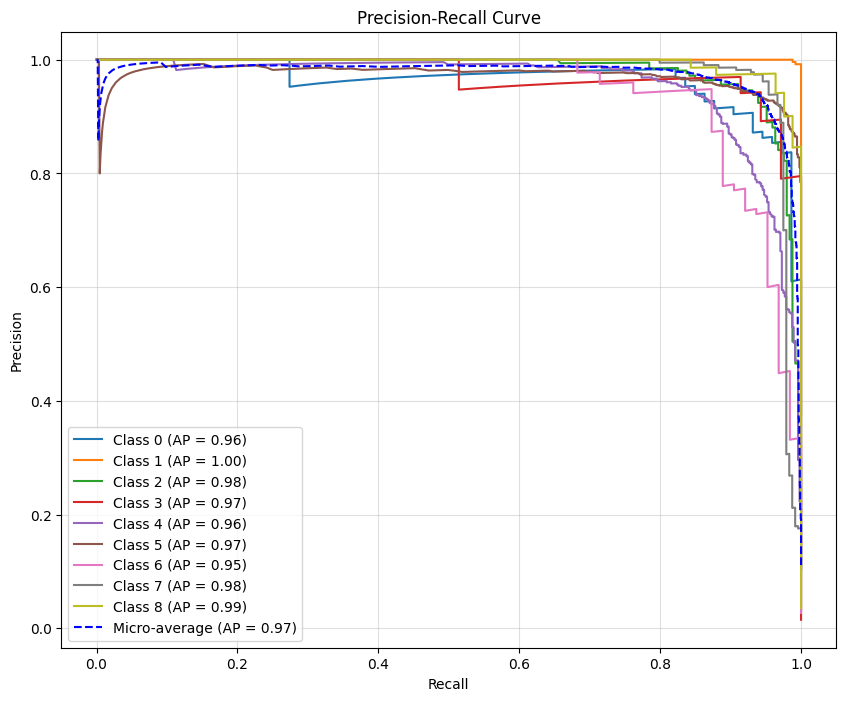

Macro-average Precision-Recall score: 0.9744


In [40]:
precision = {}
recall = {}
average_precision = {}

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_true_binarized[:, i], y_pred_probs[:, i])
    average_precision[i] = average_precision_score(y_true_binarized[:, i], y_pred_probs[:, i])

plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(recall[i], precision[i], label=f"Class {i} (AP = {average_precision[i]:.2f})")

precision_micro, recall_micro, _ = precision_recall_curve(y_true_binarized.ravel(), y_pred_probs.ravel())
average_precision_micro = average_precision_score(y_true_binarized, y_pred_probs, average="micro")
plt.plot(recall_micro, precision_micro, label=f"Micro-average (AP = {average_precision_micro:.2f})", linestyle="--", color="blue")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(loc="lower left")
plt.grid(alpha=0.4)
plt.show()

average_precision_macro = average_precision_score(y_true_binarized, y_pred_probs, average="macro")
print(f"Macro-average Precision-Recall score: {average_precision_macro:.4f}")